In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from math import factorial
from scipy.special import eval_hermitenorm
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error

## Spectral structure of a dot-product kernel under isotropic data

Given a $K(x,x') = h(\langle x, x' \rangle)$ where $h$ can be expanded in a power series $h(x) = \sum_m h_m x^m$, then the Mercer decomposition of the kernel reads:
$$
K(x,x') = \sum_m \lambda_m \sum_{|\beta| = m} He_{\beta}(x) He_{\beta}(x') 
$$
where:
$$
He_\beta(x) = \prod_{i=1}^d He_{\beta_i}(x_i)
$$

The eigenvalue are such that:
$$
\lambda_m = h_m m! \> d^{-m}
$$
provided we have normalized the trace $Tr\Sigma = 1$, hence the variances scales as $\sigma^2 = d^{-1}$. Their multeplicities is:
$$
Mol(m) = { d+m-1 \choose m}
$$
asymptotically, $Mol(m) \sim \frac{1}{m!} d^m$ with eigenvalues of order $O(d^{-m})$

Let's test these theoretical facts (empirical diagonalization)

Level 0: degeneracy = 1.0
Level 1: degeneracy = 10.0
Level 2: degeneracy = 55.0
Level 3: degeneracy = 220.0
Level 4: degeneracy = 715.0


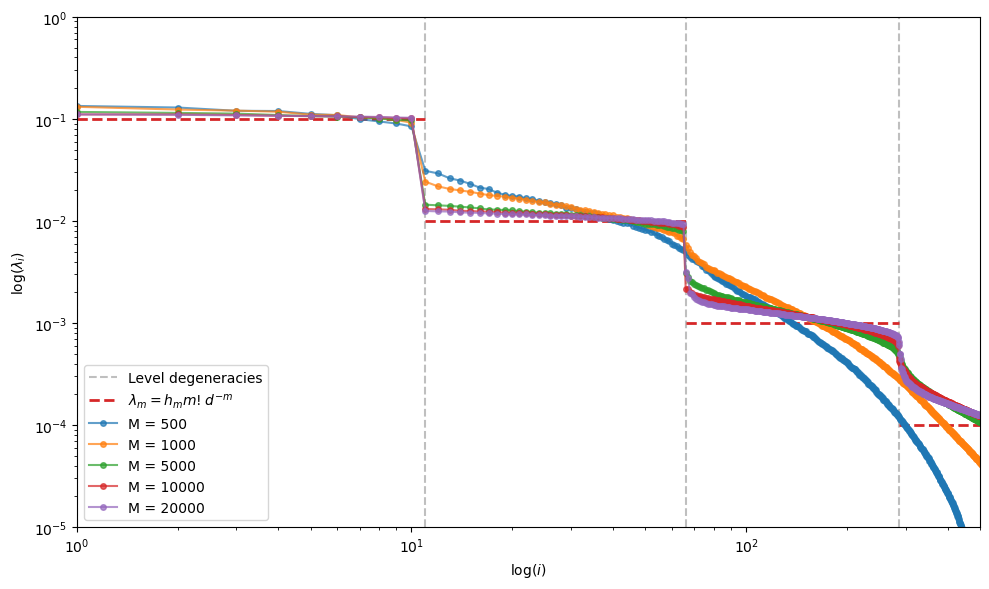

In [2]:
d = 10
def h(x):
    return np.exp(x)
taylor = [1, 1, 0.5, 1/6, 1/24] 

plt.figure(figsize=(10, 6))
# Given d, compute the degeneracies of the spectrum
coefficient = [comb(d + power - 1, power) for power in range(5)]

cumulative = 0
for i,coeff in enumerate(coefficient):
    print(f"Level {i}: degeneracy = {coeff}")
    cumulative += coeff
    plt.axvline(cumulative, color='gray', linestyle='--', alpha=0.5, label = f'Level degeneracies' if i == 0 else None)
    plt.hlines(y=pow(d, -i)*taylor[i]*factorial(i), xmin=cumulative - coeff, xmax=cumulative, color='#d62728', linestyle='--', linewidth=2, label=r'$\lambda_m = h_m m! d^{-m}$' if i == 0 else None)

#Empirical diagonalization
Ms = [500, 1000, 5000, 10000, 20000]

Sigma = np.eye(d)   # normalized covariance matrix  
Sigma *= 1/d     
for M in Ms:
    X = np.random.multivariate_normal(np.zeros(d), Sigma, M)
    Gram = X @ X.T   # This will contain the dot product between all pairs of samples
    # Now we have to apply the kernel function element-wise
    Gram = h(Gram)
    eigenvalues = np.linalg.eigvalsh(Gram)
    eigenvalues = np.sort(eigenvalues)[::-1] / M

    plt.plot(range(len(eigenvalues)), eigenvalues,  marker='o', markersize=4, alpha=0.7, label=f'M = {M}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, np.min(Ms))
plt.ylim(1e-5, 1)
plt.xlabel(r'$\log(i)$')
plt.ylabel(r'$\log(\lambda_i)$')
plt.legend()
plt.tight_layout()
plt.savefig('spectrum_plot.pdf', dpi=300)
plt.show()

Nice agreement. Hence the eigenvalues (in the isotropic case) can be resumed as:
$$
\lambda = (\lambda_0, \underbrace{\lambda_1, \dots, \lambda_1}_{g_1}, \underbrace{\lambda_2, \dots, \lambda_2}_{g_2}, ...)
$$
or
$$
\lambda = (1, \underbrace{ h_1 d^{-1}}_{d^1},  \underbrace{   2 h_2 d^{-2}}_{\frac{1}{2} d^2},  \underbrace{   6 h_3 d^{-3}}_{\frac{1}{6} d^3}, \dots)
$$
With this spectrum, we can compute analytically the generalization error. Let's start with:
$$
n - \frac{\lambda}{\nu} = Tr(\Sigma (\Sigma + \nu I)^{-1})
$$
We will make a bunch of assumptions. First of all, imagine there is no regularization constant $\lambda = 0$. Then, fix the scaling behavior of $n, d$, the sample complexity, as:
$$
n = \alpha d^\kappa
$$
where $\kappa$ is given. Now we will require that eventually $h_m = 0$ for a certain $m$ on (this is true for polynomial kernels, but we actually only need $h_m \sim 1/m!$ which is true for most functions, for example the exponential). Using the ansatz $\nu = \xi d^{-k}$
$$
\nu = d^{-k} \left(\frac{h_k}{\alpha} - h_k k! \right)
$$
Now, again, assuming a scaling $h_k \sim k!$, we'd have:
$$
\nu = -d^{-k}\left(\frac{1}{\alpha k!} - const\right)
$$
where $\exist k_0: h_k = 0, \forall k > k_0$ then $\nu = 0$ when the sample complexity is greater than $k_0$, This makes sense: when $\nu = 0$, then the bias is precisely zero, meaning that we can learn perfectly any polynomials of degree (gne, we are in the $\lambda = 0$ case remember)

Taylor coefficients: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Relative error between numerical and exact solution: ['891.57%', '151.32%', '36.57%', '10.46%', '3.20%', '1.00%', '0.32%', '0.10%', '0.03%', '0.01%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%']


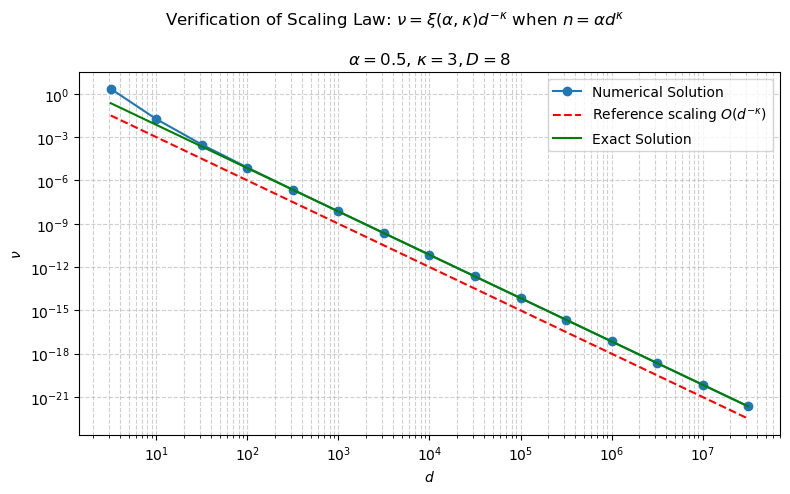

In [4]:
def get_spectrum(taylor, d, m_max=10):
    levels = []
    for m in range(m_max):
        deg = comb(d + m - 1, m)
        ev = pow(d, -m) * taylor[m] * factorial(m)
        levels.append((deg, ev))
    return levels

def solveNu_Newton(taylor, n, lambda_reg, d, max_iter=100, tol=1e-8):
    levels = get_spectrum(taylor, d, m_max=len(taylor))
    nu = 1.0 / n 
    
    for i in range(max_iter):
        df_val = 0
        df_deriv = 0
        
        for deg, ev in levels:
            ratio = ev / (ev + nu)
            df_val += deg * ratio
            df_deriv += deg * ( -ev / ((ev + nu)**2) )

        if lambda_reg > 0:
            F = n - (lambda_reg / nu) - df_val
            F_prime = (lambda_reg / (nu**2)) - df_deriv
        else:
            F = n - df_val
            F_prime = -df_deriv
            
        step = F / F_prime
        nu_new = nu - step
        
        if nu_new <= 0: 
            nu_new = nu * 0.5 
            
        if abs(step) < tol * nu:
            return nu_new
            
        nu = nu_new
    return nu


m_max = 50
# This is the pure power series expansion
#taylor = [1/factorial(m) for m in range(m_max)]
taylor = [1 if i < 7 else 0 for i in range(m_max)]  # D = 6
print("Taylor coefficients:", taylor[:15])
alpha = 0.5
kappa = 3

nus = []
d_range = [10**exp for exp in np.arange(0.5, 8, 0.5)]

for d in d_range:
    n = alpha * (d**kappa) 
    nu = solveNu_Newton(taylor, n, lambda_reg=0, d=d)
    nus.append(nu)


plt.figure(figsize=(8, 5))
plt.plot(d_range, nus, marker='o', label='Numerical Solution') 

d_values = np.array(d_range, dtype=float) 
reference = d_values**(-kappa) 

plt.plot(d_values, reference, linestyle='--', color='red', label=r'Reference scaling $O(d^{-\kappa})$')

def l(kappa, taylor):
    res = 0
    Max = len(taylor)
    for m in range(kappa+1, Max):
        res += taylor[m]/factorial(m) 
    return res


def xi(kappa, alpha, taylor):
    term = taylor[kappa] / factorial(kappa) + l(kappa, taylor) - alpha * taylor[kappa]
    xi = (1/ (2*alpha)) * (term + np.sqrt(term**2 + 4*alpha*l(kappa, taylor)*taylor[kappa]))
    return xi

derivatives = [factorial(m)*taylor[m] for m in range(m_max)]
exact_solution = [d**(-kappa)* xi(kappa, alpha, derivatives) for d in d_range ]
plt.plot(d_values, exact_solution, color='green', label=r'Exact Solution')
# relative error:
relative_error = np.abs((np.array(nus) - np.array(exact_solution)) / np.array(exact_solution)) * 100
print("Relative error between numerical and exact solution:", [f"{err:.2f}%" for err in relative_error])
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$d$') 
plt.ylabel(r'$\nu$') 
plt.suptitle(r'Verification of Scaling Law: $\nu = \xi(\alpha, \kappa) d^{-\kappa}$ when $n = \alpha d^{\kappa}$') 
plt.title(r'$\alpha = 0.5$, $\kappa = 3, D = 8$')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6) 
plt.tight_layout() 
#plt.savefig('nu_scaling.pdf', dpi=300)
plt.show()

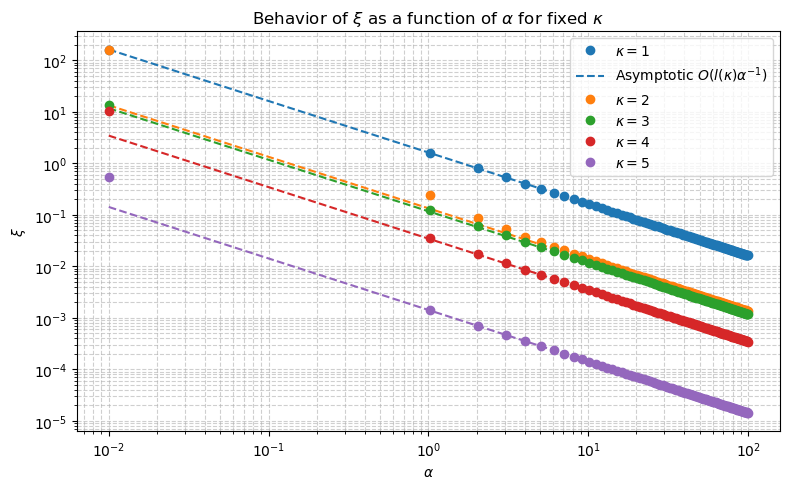

In [54]:
# What does xi look like as a function of alpha for fixed kappa?
kappas = [1,2,3,4,5]
alpha_values = np.linspace(0.01, 100, 100)
derivatives = [1,0,3,0.1,2,4,1,0.1,0.9] + [0]* (m_max - 9) # D = 9
taylor = [derivatives[m]/factorial(m) for m in range(m_max)]
plt.figure(figsize=(8, 5))

for kappa in kappas:
    xi_values = [xi(kappa, alpha, derivatives) for alpha in alpha_values]
    p = plt.plot(alpha_values, xi_values, label=r'$\kappa=' + str(kappa) + '$', marker='o', linestyle='')
    colore = p[0].get_color()
    y_teorico = alpha_values**(-1) * (l(kappa, derivatives))
    plt.plot(alpha_values, y_teorico, linestyle='--', color=colore, label=r'Asymptotic $O(l(\kappa)\alpha^{-1})$' if kappa == 1 else None)


plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\xi$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'Behavior of $\xi$ as a function of $\alpha$ for fixed $\kappa$')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

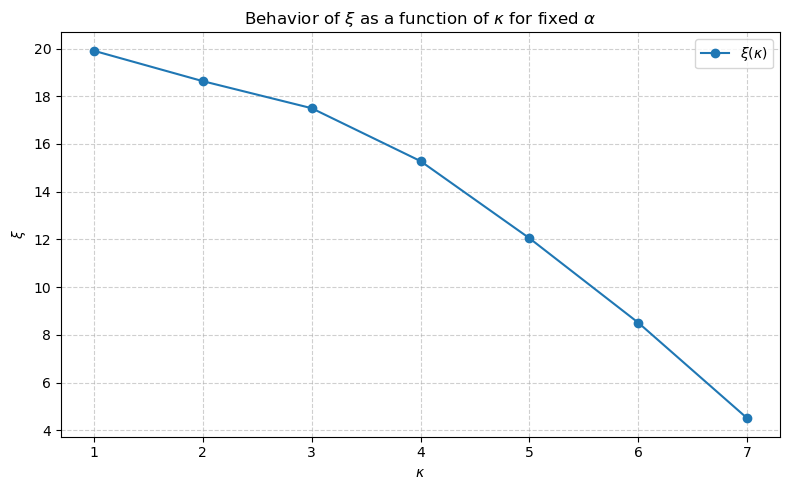

In [26]:
# What does xi look like as a function of alpha for fixed kappa?
kappa_values = [1, 2, 3, 4, 5,6,7]
alpha = 2

 
taylor = [1,2,3,0,5,6,7,8,9] + [0]* (m_max - 9) # D = 9
derivatives = [factorial(m)*taylor[m] for m in range(m_max)]
xi_values = [xi(kappa, alpha, derivatives) for kappa in kappa_values]

plt.figure(figsize=(8, 5))
plt.plot(kappa_values, xi_values, marker='o', label=r'$\xi(\kappa)$')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\xi$')
plt.title(r'Behavior of $\xi$ as a function of $\kappa$ for fixed $\alpha$')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

Now the variance computation:

Taylor coefficients: [1.0, 0.5, 0.05, 0.16666666666666666, 0.20833333333333334, 0.008333333333333333, 0.0001388888888888889, 0.0001984126984126984, 2.48015873015873e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


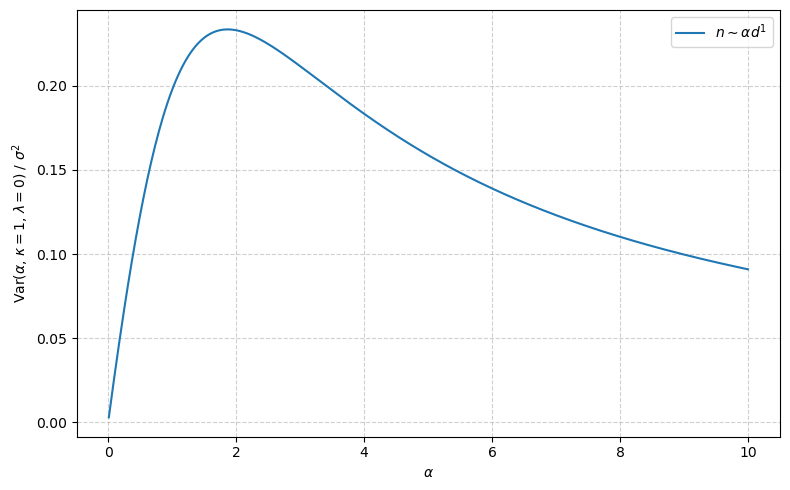

In [5]:
# What does xi look like as a function of alpha for fixed kappa?
alpha_values = np.linspace(0.01, 10, 500)
kappa = 1

m_max = 20
B = 8
derivatives = [1, 0.5, 0.1, 1, 5, 1, 0.1, 1, 1] + [0]* (m_max - B) # D = 9
taylor = [derivatives[m]/factorial(m) for m in range(m_max)]
print("Taylor coefficients:", taylor)
res = []
for alpha in alpha_values:
    xi_value = xi(kappa, alpha, derivatives)
    tau = ((derivatives[kappa]**2) / (derivatives[kappa] + xi_value)**2) / (alpha * factorial(kappa))
    term = tau / (1-tau)
    res.append(term)
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, res, label=fr'$n \sim \alpha d^{kappa}$')
plt.xlabel(r'$\alpha$')
plt.ylabel(fr'Var($\alpha$, $\kappa={kappa}$, $\lambda = 0$) / $\sigma^2$')

plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
#plt.savefig('variance.pdf', dpi=300)
plt.show()

---
### Empirical validation training a kernel!

First of all, the variance only. A finite size analysis.

In [10]:
# Helper function, l(kappa) = sum_{m > kappa} derivatives[m]/m!
def l(kappa, derivatives):
    res = 0
    Max = len(derivatives)
    for m in range(kappa+1, len(derivatives)):
        res += derivatives[m]/factorial(m) 
    return res

# Compute xi given kappa, alpha, and the derivatives of the kernel
def xi(kappa, alpha, derivatives):
    term = derivatives[kappa] / factorial(kappa) + l(kappa, derivatives) - alpha * derivatives[kappa]
    xi = (1/ (2*alpha)) * (term + np.sqrt(term**2 + 4*alpha*l(kappa, derivatives)*derivatives[kappa]))
    return xi

# Run the KRR with a given configuration (d, alpha, kappa, B, ...) and return the variance (for now)
def runKernelEmpiricalVariance(d, alpha, kappa, B, sigma, lam, n_test=5000):
    # Obtain the number of samples
    n = int(alpha * (d**kappa))
    #print(f"--- Run: d={d}, n={n} (Scaling: d^{kappa}). Using a kernel of degree {B} with reg. lambda={lam}, sig={sigma} ---")

    # Generate the training data (remember to normalize)
    X_train = np.random.randn(d, n) / np.sqrt(d)
    Y_train = sigma * np.random.randn(n) # generated outside
    
    X_test = np.random.randn(d, n_test) / np.sqrt(d)
    Y_test = np.zeros(n_test) # Variance only

    Gram_train = (1 + X_train.T @ X_train)**B  
    Gram_test = (1 + X_test.T @ X_train)**B
    model = KernelRidge(alpha=lam, kernel='precomputed')
    model.fit(Gram_train, Y_train)
    y_pred = model.predict(Gram_test)
    variance = np.mean(y_pred**2) 
    
    return variance

# Run the KRR with a given configuration (d, alpha, kappa, taylor, ...) and return the variance (for now)
def runKernelEmpiricalVarianceTaylor(d, alpha, kappa, taylor, sigma, lam, n_test=5000):
    # Obtain the number of samples
    n = int(alpha * (d**kappa))
    #print(f"--- Run: d={d}, n={n} (Scaling: d^{kappa}). Using a kernel of degree {B} with reg. lambda={lam}, sig={sigma} ---")

    # Generate the training data (remember to normalize)
    X_train = np.random.randn(d, n) / np.sqrt(d)
    Y_train = sigma * np.random.randn(n) # generated outside
    
    X_test = np.random.randn(d, n_test) / np.sqrt(d)
    Y_test = np.zeros(n_test) # Variance only

    Gram_train = np.array([[0.0]*n]*n)
    Gram_test = np.array([[0.0]*n]*n_test)
    for m in range(len(taylor)):
        Gram_train += taylor[m] * (X_train.T @ X_train)**m
        Gram_test += taylor[m] * (X_test.T @ X_train)**m
        
    model = KernelRidge(alpha=lam, kernel='precomputed')
    model.fit(Gram_train, Y_train)
    y_pred = model.predict(Gram_test)
    variance = np.mean(y_pred**2) 
    
    return variance


def computeVariance(alpha, derivatives, kappa, sigma):
    xi_value = xi(kappa, alpha, derivatives)
    tau = ((derivatives[kappa]**2) / (derivatives[kappa] + xi_value)**2) / (alpha * factorial(kappa))
    term = tau / (1-tau)
    return term*(sigma**2)

In [12]:
# Fix the value of alpha
alpha_values = [1.1]
D = [100, 200, 300, 500, 700, 1000, 2000, 3000, 4000]
kappa = 1 # linear regime
B = 3    #max degree
sigma = 2

m_max = 5
taylor = [comb(B, m) for m in range(m_max)] 
derivatives = [factorial(m)*taylor[m] for m in range(len(taylor))]
print("Taylor expansion:", taylor)


results = []
error = []
for d in D:
    print(f"Running for d={d}...")
    buffer = []
    for j in range(40):
        test_mse_sum = runKernelEmpiricalVariance(d, alpha_values[0], kappa, B, sigma, lam=0)
        buffer.append(test_mse_sum)
    test_mse = np.mean(buffer)
    # COmpute the theoretical variance
    var = computeVariance(alpha_values[0], derivatives, kappa, sigma)

    results.append((test_mse, var))
    error.append(np.std(buffer) / np.sqrt(len(buffer))) 

Taylor expansion: [1.0, 3.0, 3.0, 1.0, 0.0]
Running for d=100...
Running for d=200...
Running for d=300...
Running for d=500...
Running for d=700...
Running for d=1000...
Running for d=2000...
Running for d=3000...
Running for d=4000...


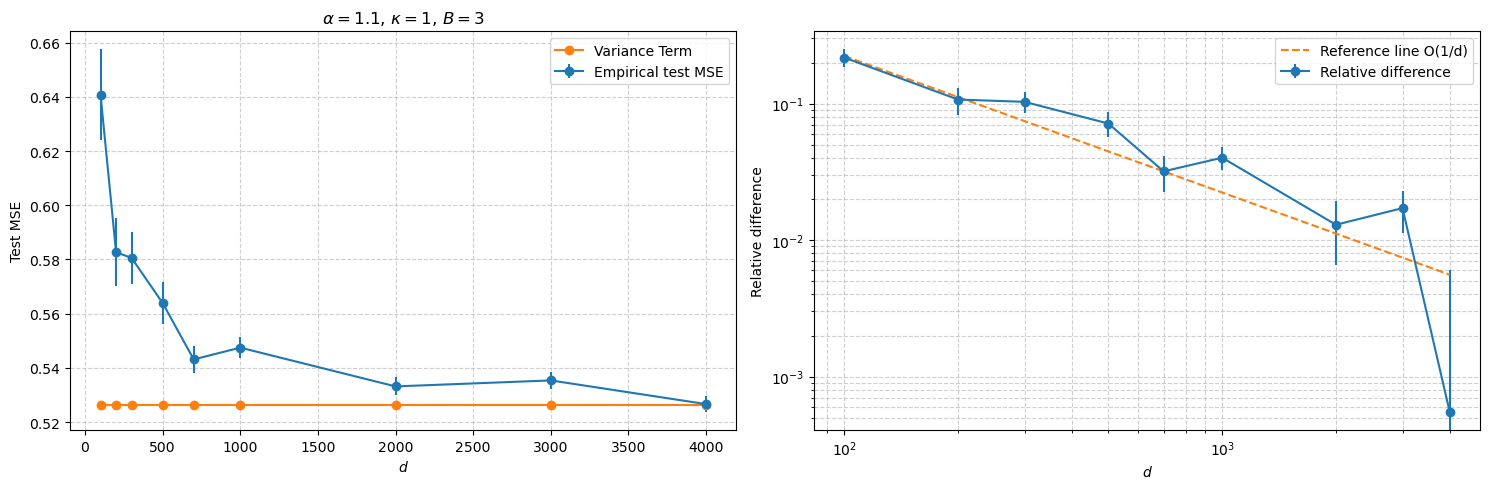

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(D, [r[0] for r in results], yerr=error, marker='o', label='Empirical test MSE')
plt.plot(D, [r[1] for r in results], marker='o', label='Variance Term')
#plt.plot(alpha_values, [r[2] for r in results], marker='o', label='Bias Term')
#plt.plot(alpha_values, [r[1]+r[2] for r in results], marker='o', label='Variance + Bias')
plt.xlabel(r'$d$')
plt.ylabel('Test MSE')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.title(fr"$\alpha = {alpha_values[0]}$, $\kappa = {kappa}$, $B = {B}$")
plt.subplot(1, 2, 2)
diff = [np.abs(r[1]-r[0])/ r[1] for r in results]
err = [e / r[1] for e, r in zip(error, results)]
plt.errorbar(D, diff, yerr=err, marker='o', label='Relative difference')
ref = np.linspace(np.min(D), np.max(D), 100)
plt.plot(ref, (D[4]*diff[4])/(ref), label='Reference line O(1/d)', linestyle='--')
plt.xlabel(r'$d$')
plt.ylabel('Relative difference')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
#plt.savefig('test_mse_variance_bias.pdf', dpi=300)
plt.show()

#### Equivalence of $l(\kappa)$ and $\lambda_{eff}$

In [41]:
alpha_values = [0.8]
d = 2000

kappa = 1 # linear regime
sigma = 2

m_max = 20

# Two models. Model 1: full expansion up to B
B = 8
taylor = [comb(B, m) for m in range(m_max)] 
derivatives = [factorial(m)*taylor[m] for m in range(len(taylor))]
print("Taylor expansion:", taylor)

buffer = []
for j in range(10):
    test_mse_sum = runKernelEmpiricalVariance(d, alpha_values[0], kappa, B, sigma, lam=0)
    buffer.append(test_mse_sum)
test_mse = np.mean(buffer)
error1 = (np.std(buffer) / np.sqrt(len(buffer)))

# Model 2:
B = 2
lambda_reg = l(kappa, derivatives)
print(f"Lambda for model 2: {lambda_reg:.4f}")
taylor = taylor[:B]
derivatives = [factorial(m)*taylor[m] for m in range(len(taylor))]
print("Taylor expansion:", taylor)
buffer2 = []
for j in range(10):
    test_mse_sum = runKernelEmpiricalVarianceTaylor(d, alpha_values[0], kappa, taylor, sigma, lam=lambda_reg)
    buffer2.append(test_mse_sum)
test_mse2 = np.mean(buffer2)
error2 = (np.std(buffer2) / np.sqrt(len(buffer2)))

print(f"Model 1 (B={B}, no reg): Test MSE = {test_mse:.4f} ± {error1:.4f}")
print(f"Model 2 (B={B}, with reg): Test MSE = {test_mse2:.4f} ± {error2:.4f}")

Taylor expansion: [1.0, 8.0, 28.0, 56.0, 70.0, 56.0, 28.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Lambda for model 2: 247.0000
Taylor expansion: [1.0, 8.0]
Model 1 (B=2, no reg): Test MSE = 0.0053 ± 0.0007
Model 2 (B=2, with reg): Test MSE = 0.0048 ± 0.0005


lambda_reg = 26.0000


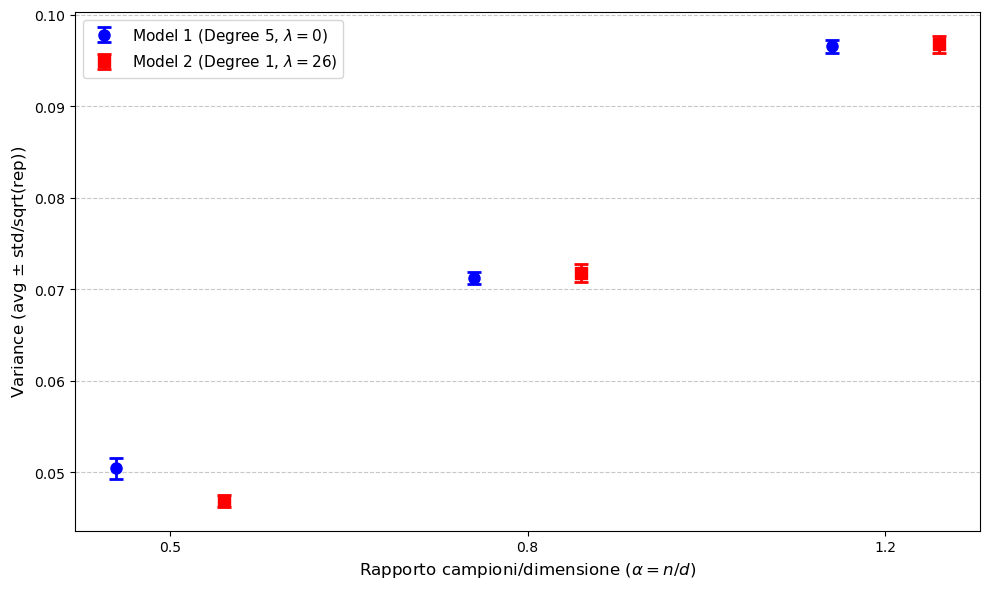

In [6]:
alpha_values = [0.5, 0.8, 1.2] 
d = 3000 #maybe larger d?

kappa = 1
sigma = 2
m_max = 20
B_full = 5

n_runs = 20 

taylor_full = [comb(B_full, m) for m in range(m_max)]
taylor_truncated = taylor_full[:kappa+1] 
derivatives_full = [factorial(m)*taylor_full[m] for m in range(len(taylor_full))]

lambda_reg = l(kappa, derivatives_full)

data_model1 = []
data_model2 = []

print(f"lambda_reg = {lambda_reg:.4f}")
for alpha in alpha_values:
    buffer1 = []
    buffer2 = []
    for j in range(n_runs):
        mse1 = runKernelEmpiricalVariance(d, alpha, kappa, B_full, sigma, lam=0)
        buffer1.append(mse1)
        
        mse2 = runKernelEmpiricalVarianceTaylor(d, alpha, kappa, taylor_truncated, sigma, lam=lambda_reg)
        buffer2.append(mse2)
    data_model1.append(buffer1)
    data_model2.append(buffer2)

means1 = [np.mean(runs) for runs in data_model1]
sems1  = [np.std(runs) / np.sqrt(len(runs)) for runs in data_model1]

means2 = [np.mean(runs) for runs in data_model2]
sems2  = [np.std(runs) / np.sqrt(len(runs)) for runs in data_model2]


fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(alpha_values))
width = 0.15 
ax.errorbar(x - width, means1, yerr=sems1, fmt='o', color='blue', 
            capsize=5, capthick=2, elinewidth=2, markersize=8, 
            label=f'Model 1 (Degree {B_full}, $\lambda = 0$)')
ax.errorbar(x + width, means2, yerr=sems2, fmt='s', color='red', 
            capsize=5, capthick=2, elinewidth=2, markersize=8, 
            label=f'Model 2 (Degree {kappa}, $\lambda = {lambda_reg:.0f}$)')

ax.set_xticks(x)
ax.set_xticklabels([f"{a:.1f}" for a in alpha_values])
ax.set_xlabel(r'Rapporto campioni/dimensione ($\alpha = n/d$)', fontsize=12)
ax.set_ylabel('Variance (avg $\pm$ std/sqrt(rep))', fontsize=12)

ax.legend(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### Bias

In [44]:
def generate_target_function(d, D):
    coeffs = {}
    for m in range(D + 1):
        betas = list(get_multi_indices(d, m))
        
        sigma = d ** (-m / 2.0)
        thetas = np.random.randn(len(betas)) * sigma
        
        coeffs.update(zip(betas, thetas))

    return coeffs

def get_multi_indices(d, m):
    if d == 1: yield (m,); return
    for i in range(m + 1):
        for suffix in get_multi_indices(d - 1, m - i):
            yield (i,) + suffix

def evaluate_model_fast(X, coeffs):

    n_samples = X.shape[1]
    y_pred = np.zeros(n_samples)
    d = X.shape[0]
    
    for beta, theta in coeffs.items():
        term = np.ones(n_samples)
        for dim, degree in enumerate(beta):
            if degree > 0:
                term *= eval_hermitenorm(degree, X[dim, :] * np.sqrt(d)) / (np.sqrt(factorial(degree)))
        
        y_pred += theta * term
        
    return y_pred

def ThetaSum(kappa, components):
    return sum(theta**2 for beta, theta in components.items() if sum(beta) > kappa)

def computeBias(alpha, derivatives, kappa, coeffs):
    xi_value = xi(kappa, alpha, derivatives)
    tau = ((derivatives[kappa]**2) / (derivatives[kappa] + xi_value)**2) / (alpha * factorial(kappa))
    denominator = 1 - tau
    num1 = ThetaSum(kappa, coeffs) 
    num2 = ((xi_value**2) / (derivatives[kappa] + xi_value)**2) * sum(theta**2 for beta, theta in coeffs.items() if sum(beta) == kappa)
    bias = ((num1 + num2) / denominator) 
    return bias

# Run the KRR with a given configuration (d, alpha, kappa, taylor, ...) and return the variance (for now)
def runKernelEmpirical(d, alpha, kappa, B, sigma, lam,  coeff, n_test=5000):
    # Obtain the number of samples
    n = int(alpha * (d**kappa))
    #print(f"--- Run: d={d}, n={n} (Scaling: d^{kappa}). Using a kernel of degree {B} with reg. lambda={lam}, sig={sigma} ---")

    # Generate the training data (remember to normalize)
    X_train = np.random.randn(d, n) / np.sqrt(d)
    Y_train = evaluate_model_fast(X_train, coeff) + sigma * np.random.randn(n)
    
    X_test = np.random.randn(d, n_test) / np.sqrt(d)
    Y_test = evaluate_model_fast(X_test, coeff)

    Gram_train = (1+ X_train.T @ X_train)**B
    Gram_test = (1 + X_test.T @ X_train)**B
        
    model = KernelRidge(alpha=lam, kernel='precomputed')
    model.fit(Gram_train, Y_train)
    y_pred = model.predict(Gram_test)
    totalError = np.mean((y_pred - Y_test)**2) 
    
    return totalError


def generate_sparse_target_function(d, D, num_active_per_shell=200):
    coeffs = {}
    
    # Per ogni grado m da 1 fino a D
    for m in range(1, D + 1):
        
        # Calcoliamo la deviazione standard per far combaciare la teoria
        # La varianza totale del guscio deve essere 1/m!
        sigma = np.sqrt(1.0 / (num_active_per_shell * factorial(m)))
        
        for _ in range(num_active_per_shell):
            # Lancia m palline in d dimensioni (genera un array di lunghezza d)
            beta_array = np.random.multinomial(m, np.ones(d)/d)
            beta = tuple(beta_array) # Convertiamo in tupla per usarla come chiave
            
            # Generiamo il coefficiente pesato correttamente
            theta = np.random.randn() * sigma
            
            # Se per caso peschiamo lo stesso beta due volte, sommiamo i coefficienti
            if beta in coeffs:
                coeffs[beta] += theta
            else:
                coeffs[beta] = theta

    return coeffs

In [47]:
# Fix the value of alpha
alpha_values = [0.8]
D = [100, 200, 300, 500, 700, 1000, 2000, 4000]
kappa = 1 # linear regime
B = 5    #max degree of the kernel
Bt = 2    #max degree of the target function
sigma = 2

m_max = B+1
taylor = [comb(B, m) for m in range(m_max)] 
derivatives = [factorial(m)*taylor[m] for m in range(len(taylor))]
print("Taylor expansion:", taylor)


results = []
error = []

for d in D:
    print(f"Running for d={d}...", end=' ')
    coeff = generate_sparse_target_function(d, Bt)
    print(f"Number of coefficients: {len(coeff)}")
    buffer = []
    for j in range(50):
        test_mse_sum = runKernelEmpirical(d, alpha_values[0], kappa, B, sigma, 0, coeff)
        buffer.append(test_mse_sum)
    test_mse = np.mean(buffer)
    # Compute the theoretical variance
    var = computeVariance(alpha_values[0], derivatives, kappa, sigma)
    bias = computeBias(alpha_values[0], derivatives, kappa, coeff)

    results.append((test_mse, var, bias))
    error.append(np.std(buffer) / np.sqrt(len(buffer))) 

Taylor expansion: [1.0, 5.0, 10.0, 10.0, 5.0, 1.0]
Running for d=100... Number of coefficients: 279
Running for d=200... Number of coefficients: 322
Running for d=300... Number of coefficients: 346
Running for d=500... Number of coefficients: 366
Running for d=700... Number of coefficients: 373
Running for d=1000... Number of coefficients: 383
Running for d=2000... Number of coefficients: 391
Running for d=4000... Number of coefficients: 395


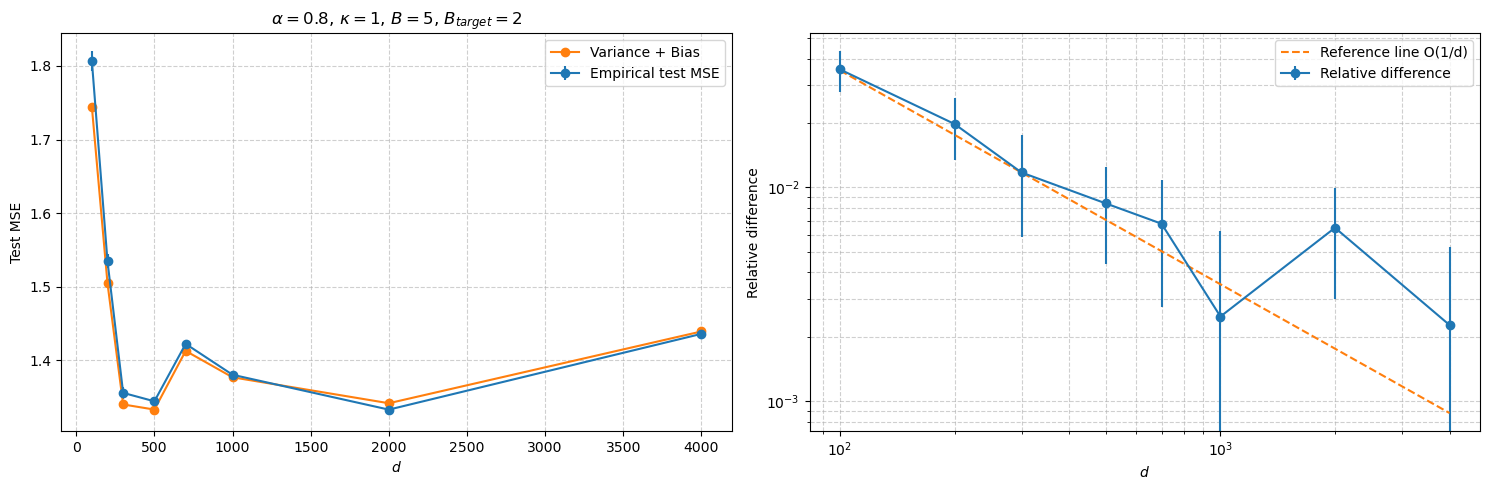

In [48]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(D, [r[0] for r in results], yerr=error, marker='o', label='Empirical test MSE')
#plt.plot(D, [r[1] for r in results], marker='o', label='Variance Term')
#plt.plot(D, [r[2] for r in results], marker='o', label='Bias Term')
plt.plot(D, [r[1]+r[2] for r in results], marker='o', label='Variance + Bias')
plt.xlabel(r'$d$')
plt.ylabel('Test MSE')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.title(fr"$\alpha = {alpha_values[0]}$, $\kappa = {kappa}$, $B = {B}$, $B_{{target}} = {Bt}$")
plt.subplot(1, 2, 2)
diff = [np.abs((r[1]+r[2])-r[0])/ (r[1]+r[2]) for r in results]
err = [e / (r[1]+r[2]) for e, r in zip(error, results)]
plt.errorbar(D, diff, yerr=err, marker='o', label='Relative difference')
ref = np.linspace(np.min(D), np.max(D), 100)
plt.plot(ref, (D[2]*diff[2])/(ref), label='Reference line O(1/d)', linestyle='--')
plt.xlabel(r'$d$')
plt.ylabel('Relative difference')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
#plt.savefig('test_mse_variance_bias_sparse.pdf', dpi=300)
plt.show()

In [ ]:
# Fix the value of alpha
alpha_values = [0.1, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.5, 2]
D = [1000]

kappa = 1 # linear regime
B = 5    #max degree of the kernel
Bt = 2    #max degree of the target function
sigma = 2

m_max = B+1
taylor = [comb(B, m) for m in range(m_max)] 
derivatives = [factorial(m)*taylor[m] for m in range(len(taylor))]
print("Taylor expansion:", taylor)


results = []
error = []

coeff = generate_sparse_target_function(D[0], Bt)
print(f"Number of coefficients: {len(coeff)}")
for alpha in alpha_values:
    print(f"Running for alpha={alpha}...", end=' ')
    buffer = []
    for j in range(50):
        test_mse_sum = runKernelEmpirical(D[0], alpha, kappa, B, sigma, 0, coeff)
        buffer.append(test_mse_sum)
    test_mse = np.mean(buffer)
    # Compute the theoretical variance
    var = computeVariance(alpha, derivatives, kappa, sigma)
    bias = computeBias(alpha, derivatives, kappa, coeff)

    results.append((test_mse, var, bias))
    error.append(np.std(buffer) / np.sqrt(len(buffer))) 

Taylor expansion: [1.0, 5.0, 10.0, 10.0, 5.0, 1.0]
Number of coefficients: 384
Running for alpha=0.1... Running for alpha=0.5... Running for alpha=0.7... Running for alpha=0.8... Running for alpha=0.9... Running for alpha=1... Running for alpha=1.1... Running for alpha=1.5... Running for alpha=2... 

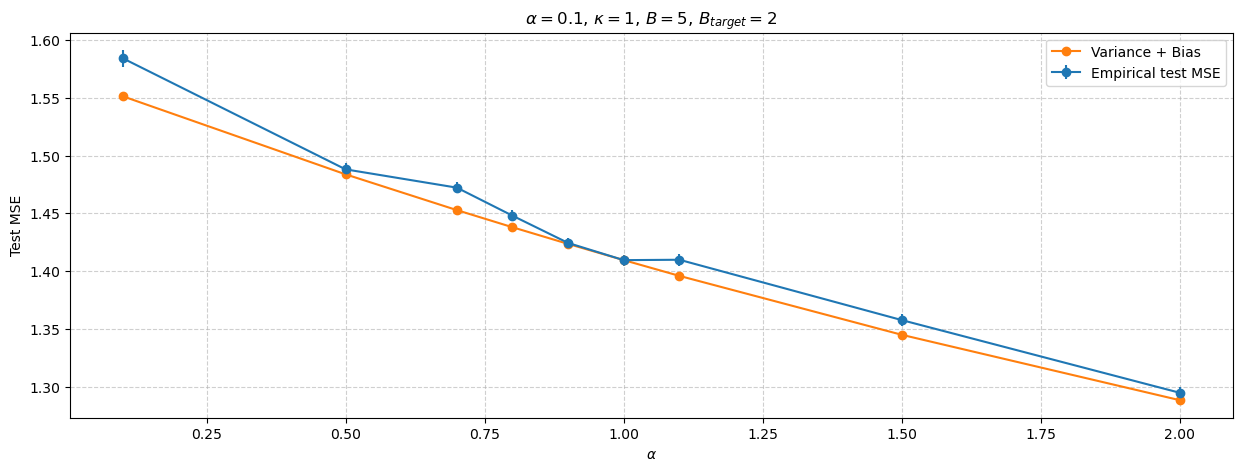

In [58]:
plt.figure(figsize=(15, 5))
plt.errorbar(alpha_values, [r[0] for r in results], yerr=error, marker='o', label='Empirical test MSE')
#plt.plot(D, [r[2] for r in results], marker='o', label='Bias Term')
plt.plot(alpha_values, [r[1]+r[2] for r in results], marker='o', label='Variance + Bias')
plt.xlabel(r'$\alpha$')
plt.ylabel('Test MSE')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.title(fr"$\alpha = {alpha_values[0]}$, $\kappa = {kappa}$, $B = {B}$, $B_{{target}} = {Bt}$")
plt.show()